# 중고차 가격 예측 경진대회 첫 번째 베이스라인

이번 대회는 중고차 시장 데이터를 이용하여 중고차 가격 예측을 예측하는 대회입니다.

언뜻보면 간단해 보이지만 처음 데이터 분석을 접하시는 분들에게는 어디부터 어떻게 시작해야 하는지 막막하실 겁니다.

## 누구나 할 수 있는 데이터 분석
딥러닝, 머신러닝, 모델, 학습, 회귀분석 .... 다 몰라도 괜찮습니다!

누구나 할 수 있는 방식으로 간단하게 데이터 분석 & 예측을 진행해보겠습니다.


## 데이터 불러오기

In [1]:
import pandas as pd ## pandas 라이브러리를 가져오기 위하여 import를 해줍니다.

# csv 형식으로 된 데이터 파일을 읽어옵니다.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'train data set은 {train.shape[1]} 개의 feature를 가진 {train.shape[0]} 개의 데이터 샘플로 이루어져 있습니다.')

# 데이터의 최상단 5 줄을 표시합니다.
train.head()

train data set은 11 개의 feature를 가진 1015 개의 데이터 샘플로 이루어져 있습니다.


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


트레인과 테스트 데이터 모양 행과 열을 살펴보면 다음과 같습니다.

In [2]:
print(train.shape, test.shape)

(1015, 11) (436, 10)


## 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [3]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


중고차 가격 예측 하기 위한 데이터는 결측치가 존재하지 않은 것으로 확인되었습니다.

## 데이터 전처리


info() 메소드를 이용하여 데이터의 타입을 살펴보겠습니다.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


title, location 등 많은 데이터 컬럼이 **object형** 데이터 이군요!

머신러닝 알고리즘은 문자열 데이터 속성을 입력받지 않으며 모든 데이터는 숫자형으로 표현되어야 합니다.

그래서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩 되어야 합니다.

**'Label Encoding'** 을 통해서 문자형을 숫자 값으로 변환해보겠습니다.

Label Encoding이란, 범주형 변수의 문자열을 수치형으로 변환하는 방법 중 하나입니다.

우리 데이터에는 문자로 이루어진 피쳐를 Label Encoding을 통해 숫자형으로 표현해보겠습니다.

In [5]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

{'title': {'unknown': 0, 'Toyota RAV 4': 1, 'Toyota Land Cruiser': 2, 'Land Rover Range Rover Evoque': 3, 'Lexus ES 350': 4, 'Toyota Venza': 5, 'Toyota Corolla': 6, 'Land Rover Range Rover Sport': 7, 'Pontiac Vibe': 8, 'Toyota Tacoma': 9, 'Lexus RX 350': 10, 'Ford Escape': 11, 'Honda Civic': 12, 'Volvo XC90': 13, 'BMW 750': 14, 'Infiniti JX': 15, 'Honda Accord': 16, 'Mercedes-Benz ML 350': 17, 'Toyota Camry': 18, 'Hyundai Azera': 19, 'Lexus GX 460': 20, 'BMW 325': 21, 'Toyota Sienna': 22, 'Honda Fit': 23, 'Honda CR-V': 24, 'Hyundai Tucson': 25, 'Ford Transit': 26, 'Jaguar XJ8': 27, 'BMW X6': 28, 'Mercedes-Benz C 300': 29, 'Mitsubishi Galant': 30, 'Mercedes-Benz GL 450': 31, 'Lexus RX 300': 32, 'Toyota Highlander': 33, 'Mitsubishi CANTER PICK UP': 34, 'Nissan Titan': 35, 'Lexus IS 250': 36, 'Mercedes-Benz 200': 37, 'Toyota Sequoia': 38, 'Ford Explorer': 39, 'Hyundai ix35': 40, 'Mack CH613 CONVENTIONAL CAB': 41, 'Lexus CT 200h': 42, 'Lexus LX 570': 43, 'Toyota Avensis': 44, 'Toyota 4-Run

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,1,18277,1,1,1,1,1,1,2016,13665000
1,1,2,10,2,2,1,1,1,2,2019,33015000
2,2,3,83091,2,1,2,1,1,1,2012,9915000
3,3,4,91524,2,1,1,1,1,3,2007,3815000
4,4,5,94177,2,1,2,1,1,1,2010,7385000


## 모델링

### 변수 정의

이제 본격적으로 모델을 설계하기 위해 데이터를 독립변수(X)와 종속변수(y) 로 나누어 줍니다

우리의 목적은 주어진 중고차 시장 데이터를 이용하여 자동차 가격(target)을 예측하는 것입니다.

그럼 가격을 제외한 중고차 시장 데이터가 X, 중고차 가격(target)이 y가 되겠죠?

In [6]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 중고차 가격 추출

이렇게 X와 y를 잘 정의해주었습니다.

<br>

### train/vaildation 정의

이제 우리는 모델을 만들어야 하는데,
모델을 만들기 앞서 내가 만들 모델이 유의미한지 알아야 좋은 결론을 도출 할 수 있겠죠?

<br>

하지만 단순히 주어진 데이터로 train셋 데이터를 학습시켜서 목표값인 test 셋에 집어 넣어 예측값을 도출하면,
모델이 적합한지 알 방법이 없습니다.

<br>

따라서 train 셋에서 70%를 학습을 시키는데 쓰고, 나머지 25%를 모델이 유의미한지 검증하는데 사용할 것입니다.
이후 유의미하다면, 실제로 제출할 모델을 만들 때, train 셋 100%를 학습을 시키면 되겠죠?

<br>

자 그럼 train 셋에서 학습시킬 셋 train_data와 검증할 셋 val_data를 만들어 봅시다!

In [7]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.25) #25프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

In [8]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (761, 11)
검증할 val 셋 :  (254, 11)


위의 데이터 모양을 보면,

**761개의 데이터를 학습**시켜

**254개의 데이터로 성능을 검증**시킬 것 입니다!

In [9]:
train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 target 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #validation 데이터에서 target 추출

이번 베이스라인에서는 대표적인 ML모델의 하나인 RandomForest 모델을 사용해봅시다.

<br>

RandomForest 알고리즘에서 사용되는 의사 결정 트리는 feature 별 가지치기를 통해 데이터를 학습하는 알고리즘입니다.

의사 결정 나무에 대한 자세한 개념 설명은 데이콘 [오늘의 파이썬](https://dacon.io/competitions/open/235698/talkboard/403509?page=1&dtype=recent)을 참고해 주세요!

의사 결정 나무는 데이터를 쉽게 학습하는 알고리즘이지만 하나의 의사 결정 나무를 사용하는 것은 과적합(overfitting)의 문제를 발생 시킬 수 있습니다.

여기서 과적합(overfitting)이란 학습 데이터에 과하게 학습되어 새로운 데이터를 예측하지 못하는 문제를 말합니다.

쉽게 말해 우리가 공부를 할때 암기식으로 공부를 하여 새로운 문제를 해결하지 못하는 것 입니다!

<br>
RandomForest는 여러개의 의사 결정 나무를 활용하여 과적합의 문제를 해결합니다.

여러개의 의사 결정 트리를 활용하면 하나의 트리에 대한 의존도가 낮아집니다.

이는 하나의 트리가 과적합이 되어도 전체 모델은 과적합의 문제에서 벗어날 수 있음을 의미합니다.

sklearn 패키지를 이용하면 직접 RandomForest를 구현하지 않고 모델을 사용할 수 있습니다.

이번 베이스라인에서는 sklearn에서 제공하는 RandomForestRegressor 모델로 문제를 해결해보도록 하겠습니다.

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() # 모델 정의
model.fit(train_data_X, train_data_y) # 학습

RandomForestRegressor()

굉장히 간단하게 학습이 끝났습니다.

모델이 실제로 데이터를 얼마나 잘 맞추는지 확인해볼까요?

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))

    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.40696511442697647


NMAE로 계산하여 0.353가 나왔습니다.

좋은 수치일까요 나쁜 수치일까요?

NMAE 0.353는 대략 예측치와 실제값이 35.3% 정도의 오차율을 보인다는 것을 의미합니다.

어떠신가요 여러분은 만족하시나요?

### Vaildation 예측값 눈으로 확인하기

0.353라는 숫자만 봐서는 모델이 어떤방식으로 맞췄는지 어디에서 오차가 더 많이 나는지 알 수 없습니다.

모델을 개선시키기 위해선 어느 포인트에서 예측을 하지 못했는지 모델의 약점을 알아야합니다.

그러기 위한 방법중 하나가 바로 오답노트인데요

여러분은 데이콘 제출페이지에 제출하는 방식으로 스코어를 확인할수도, train set의 정확도가 어느정도 나오는지 눈으로 확인할 수도 있습니다.

train set에서 오답노트를 확인하는것은 자칫 overfitting시킬 수 있어 조심해야하는 부분이지만 여러분에게 어느정도 인사이트를 줄 수도 있을겁니다.

그럼 plot을 그려서 확인해 보겠습니다.

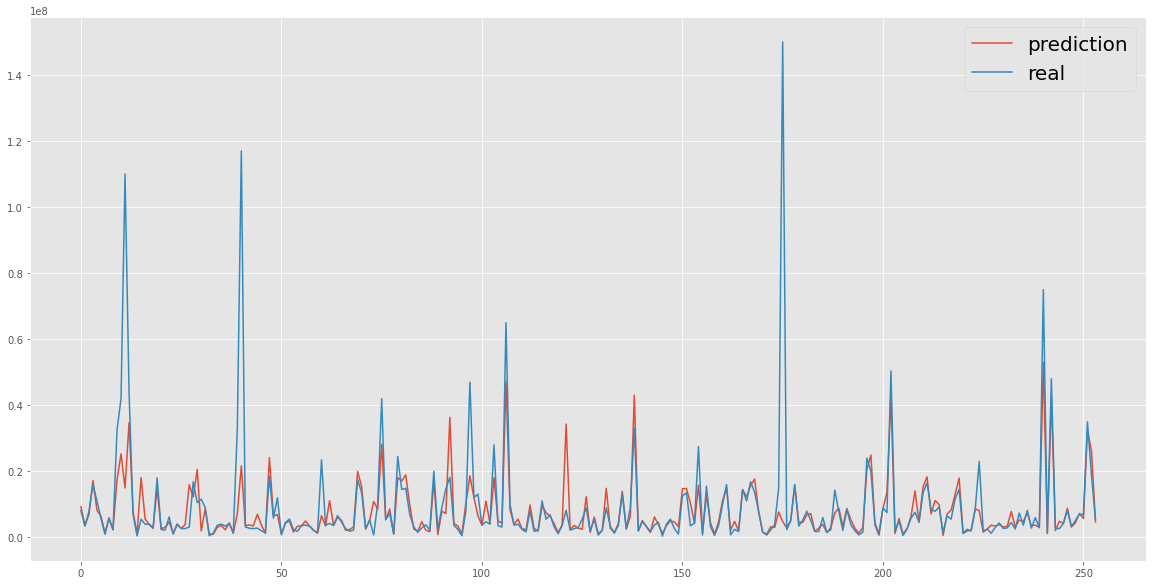

In [12]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

파란선이 실제 따릉이 소비량, 붉은 선이 우리의 모델이 예측한 값입니다.

여러분이 보기에는 어떠신가요?

우리의 모델이 어느정도 예측을 하고 있는것같나요?

'추세는 따라가고 있는것 같다'정도는 이야기할 수 있을것 같습니다.

### train 셋 + val 셋 100% 활용하는 모델 만들기

이제 검증 셋으로 성능이 유의미한지 확인을 하였다면 데이터를 100% 활용하기 위하여
검증 셋을 포함한 train 셋을 만들어보겠습니다.

In [13]:
train_X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 target 추출

In [14]:
train_X

,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,1,18277,1,1,1,1,1,1,2016
1,2,10,2,2,1,1,1,2,2019
2,3,83091,2,1,2,1,1,1,2012
3,4,91524,2,1,1,1,1,3,2007
4,5,94177,2,1,2,1,1,1,2010
...,...,...,...,...,...,...,...,...,...
1010,6,46768,2,1,1,1,1,2,2014
1011,18,31600,3,1,1,1,1,7,2011
1012,18,96802,3,1,1,1,1,2,2011
1013,20,146275,2,1,2,1,1,15,2013


In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(train_X, train_y) # 모델 학습

RandomForestRegressor()

## 예측하기

이제 학습된 모델을 이용하여 주어진 test데이터로 예측을 진행해 보겠습니다.

앞서 train 셋에서 했던 동일한 전처리 과정을 거치되, data leakage가 발생하지 않도록 주의합니다.

In [16]:
check_missing_col(test) # 결측치 확인

test = test.drop('id', axis = 1) #분석에 필요없는 열 삭제

test = label_encoder(test, le) #범주형 피쳐 라벨인코딩

test.head()

결측치가 존재하지 않습니다


,title,odometer,location,isimported,engine,transmission,fuel,paint,year
0,29.0,1234,3.0,2,1.0,1,1,4.0,2017
1,16.0,29938,3.0,1,1.0,1,1,4.0,2013
2,0.0,87501,2.0,1,1.0,1,1,2.0,2012
3,22.0,180894,2.0,3,2.0,1,1,10.0,2001
4,85.0,104814,2.0,1,1.0,1,1,4.0,2000


전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.

In [17]:
y_pred = model.predict(test)
y_pred[0:5]

array([20837650.,  5921950.,  5284000.,  1234400.,  2304700.])

## Dacon 대회에 제출하기 (Submission)

이제 학습한 모델을 사용하여 이 예측 결과를 submit1.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [19]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [20]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = y_pred

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,20837650.0
1,1,5921950.0
2,2,5284000.0
3,3,1234400.0
4,4,2304700.0


submission을 csv 파일로 저장합니다.
index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다.
정확한 채점을 위해 꼭 index=False를 넣어주세요.

In [22]:
submission.to_csv('submit1.csv', index=False)